In [55]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import math
import os
import warnings
from collections import OrderedDict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

try:
    from scipy import stats
except Exception:  # pragma: no cover - SciPy is optional
    stats = None
    warnings.warn(
        "SciPy is not available; paired t-test p-values will be reported as NaN.",
        RuntimeWarning,
    )

warnings.filterwarnings("ignore")

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

sns.set_theme(style="whitegrid")

In [ ]:
# Configuration
# ----------------------------------------------------------------------
#HERE: COMMENT OUT PATHS YOU DON'T WANT TO RUN. For example, run analysis only for experimental day types. 
# Will automatically separate halt and no halt
# Root directories containing cohort-level folders with aligned data.
DATA_DIRS: List[Path] = [
    Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day4/").expanduser(),
    Path("/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day4/").expanduser(),
    # Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3").expanduser(),
    # Path("/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day3/").expanduser(),
]

OUTPUT_SUBDIR_NAME = "turning_analysis"

# Event file suffixes that encode turn direction in their names.
EVENT_SUFFIXES: List[str] = [
    "_Apply halt_2s_right_turns_baselined_data.csv",
    "_Apply halt_2s_left_turns_baselined_data.csv",
    "_No halt_right_turns_baselined_data.csv",
    "_No halt_left_turns_baselined_data.csv",
]

# Optional subset of mice to analyse (use [] to include every mouse found).
SELECTED_MICE: List[str] = []

# Columns and time windows used for the velocity check.
TIME_COLUMN = "Time (s)"
VELOCITY_COLUMN = "Motor_Velocity_Baseline" #"Motor_Velocity_Baseline"
RUNNING_COLUMN = "Velocity_0X_Baseline" #"Velocity_0X_Baseline"
PRE_WINDOW = (-1.0, 0.0)   # seconds relative to alignment (before 0)
POST_WINDOW = (0.0, 1.0)   # seconds relative to alignment (after 0)

# Threshold in deg/s to treat near-zero averages as no turn (avoid noisy sign flips).
ZERO_THRESHOLD = 1e-2 #FIXME where is this used?

# Windows used for timing and magnitude metrics.
PEAK_WINDOW = (0.0, 1.0)     #FIXME THIS GETS OVERWRITTEN LATER ANYWAY TO 0-1s (as shown in plots)
AUC_WINDOW = (0.0, 1.0)      # integration window for turn area (s)
DECAY_FIT_WINDOW = (0.0, 3.0)  # window (s) used to estimate decay time constant
LATENCY_FRACTION = 0.5       #FIXME deprecated but needs to stay here??

# Mapping from inferred turn direction to expected velocity sign after time 0.
# Here we expect the actual turn to be opposite the label in the filename.
EXPECTED_DIRECTION_SIGN = {
    "right": -1,  # filenames tagged "right" should result in negative velocity
    "left": 1,    # filenames tagged "left" should result in positive velocity
}

In [57]:
# Utility functions
# ----------------------------------------------------------------------

def _iter_raw_mouse_dirs(data_dirs: Iterable[Path]) -> Iterable[Tuple[str, Path]]:
    """Yield (mouse_id, raw_dir) pairs for each mouse found in the data dirs."""
    for data_dir in data_dirs:
        base = Path(data_dir)
        if not base.exists():
            print(f"⚠️ Data directory not found: {base}")
            continue

        if base.is_dir() and base.name.endswith("_processedData"):
            raw_dir = base.with_name(base.name.replace("_processedData", ""))
            if raw_dir.exists():
                mouse_id = raw_dir.name.split("-")[0]
                yield mouse_id, raw_dir
            else:
                print(f"⚠️ Raw directory for processed data not found: {base}")
            continue

        if not base.is_dir():
            continue

        candidate_mouse_dirs = [
            subdir
            for subdir in base.iterdir()
            if subdir.is_dir() and "-" in subdir.name and not subdir.name.endswith("_processedData")
        ]
        if candidate_mouse_dirs:
            for subdir in candidate_mouse_dirs:
                mouse_id = subdir.name.split("-")[0]
                yield mouse_id, subdir
            continue

        mouse_id = base.name.split("-")[0]
        yield mouse_id, base


def find_turn_event_files(
    data_dirs: Iterable[Path],
    event_suffixes: Iterable[str],
    selected_mice: Optional[Iterable[str]] = None,
) -> List[Dict[str, object]]:
    """Locate aligned CSV files whose names encode turn direction."""
    selected = set(selected_mice or [])
    matches: List[Dict[str, object]] = []

    for mouse_id, raw_dir in _iter_raw_mouse_dirs(data_dirs):
        if selected and mouse_id not in selected:
            continue

        aligned_dir = raw_dir.parent / f"{raw_dir.name}_processedData" / "aligned_data"
        if not aligned_dir.exists():
            continue

        for suffix in event_suffixes:
            csv_path = aligned_dir / f"{mouse_id}{suffix}"
            if not csv_path.exists():
                continue
            direction = infer_direction_from_name(csv_path.name)
            group = infer_event_group(suffix)
            matches.append(
                {
                    "mouse": mouse_id,
                    "direction": direction,
                    "group": group,
                    "event_suffix": suffix,
                    "csv_path": csv_path,
                }
            )

    return matches


def infer_direction_from_name(filename: str) -> str:
    name = filename.lower()
    if "right" in name:
        return "right"
    if "left" in name:
        return "left"
    return "unknown"


def infer_event_group(name: str) -> str:
    lower = name.lower()
    if "no_halt" in lower or "no halt" in lower:
        return "No halt"
    if "apply" in lower:
        return "Apply halt"
    return "Unknown"


def load_time_series(
    csv_path: Path,
    time_column: str,
    value_column: str,
    value_alias: str = "velocity",
) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in {csv_path}")
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not found in {csv_path}")
    subset = df[[time_column, value_column]].copy()
    subset = subset.dropna()
    subset = subset.rename(columns={time_column: "time", value_column: value_alias})
    subset["time"] = pd.to_numeric(subset["time"], errors="coerce")
    subset[value_alias] = pd.to_numeric(subset[value_alias], errors="coerce")
    subset = subset.dropna()
    subset = subset.sort_values("time")
    return subset


def load_motor_velocity(
    csv_path: Path,
    time_column: str,
    velocity_column: str,
) -> pd.DataFrame:
    return load_time_series(csv_path, time_column, velocity_column, value_alias="velocity")


def compute_window_mean(df: pd.DataFrame, window: Tuple[float, float]) -> float:
    start, end = window
    mask = (df["time"] >= start) & (df["time"] < end if start < end else df["time"] <= end)
    if not mask.any():
        return float("nan")
    return float(df.loc[mask, "velocity"].mean())


def sign_with_threshold(value: float, threshold: float) -> int:
    if not math.isfinite(value) or abs(value) <= threshold:
        return 0
    return 1 if value > 0 else -1


def sem(values) -> float:
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n <= 1:
        return 0.0 if n == 1 else float("nan")
    return float(arr.std(ddof=1) / np.sqrt(n))


def fit_exponential_decay(time_values: Iterable[float], amplitude_values: Iterable[float]) -> float:
    time_arr = np.asarray(time_values, dtype=float)
    amp_arr = np.asarray(amplitude_values, dtype=float)
    mask = np.isfinite(time_arr) & np.isfinite(amp_arr)
    if mask.sum() < 3:
        return float("nan")
    time_arr = time_arr[mask]
    amp_arr = amp_arr[mask]
    amp_arr = np.abs(amp_arr)
    positive_mask = amp_arr > 0
    if positive_mask.sum() < 3:
        return float("nan")
    time_arr = time_arr[positive_mask]
    amp_arr = amp_arr[positive_mask]
    time_arr = time_arr - time_arr.min()
    if time_arr.ptp() <= 0:
        return float("nan")
    log_amp = np.log(amp_arr)
    slope, intercept = np.polyfit(time_arr, log_amp, 1)
    if slope >= 0:
        return float("nan")
    tau = -1.0 / slope
    return float(tau)


def assign_mouse_colors_consistent(mouse_ids: Iterable[str]) -> Dict[str, tuple]:
    normalized = [str(mouse) for mouse in mouse_ids]
    unique_mice = sorted(dict.fromkeys(normalized))
    if not unique_mice:
        return OrderedDict()
    palette = sns.color_palette("gnuplot2", len(unique_mice))
    return OrderedDict((mouse, palette[idx]) for idx, mouse in enumerate(unique_mice))


def _sanitize_label(value: str) -> str:
    cleaned = re.sub(r"[^\w\-]+", "_", value)
    cleaned = re.sub(r"_+", "_", cleaned)
    return cleaned.strip("_")


def build_output_folder_name(base_name: str, data_dirs: Iterable[Path]) -> str:
    labels: List[str] = []
    for directory in data_dirs:
        try:
            path = Path(directory).expanduser()
        except Exception:
            continue
        if not path.exists():
            continue
        cohort = path.parent.name if path.parent != path else ""
        day = path.name
        parts = [part for part in (cohort, day) if part]
        if not parts:
            continue
        label = _sanitize_label("_".join(parts))
        if not label:
            continue
        if label not in labels:
            labels.append(label)
    if not labels:
        return base_name
    suffix = "__".join(labels)
    return f"{base_name}__{suffix}"


def determine_output_directory(data_dirs: Iterable[Path], folder_name: str) -> Optional[Path]:
    existing_dirs = []
    for directory in data_dirs:
        candidate = Path(directory).expanduser()
        if candidate.exists():
            existing_dirs.append(candidate)
    if not existing_dirs:
        print("⚠️ No existing data directories found; results will not be saved.")
        return None

    folder_name = build_output_folder_name(folder_name, existing_dirs)
    try:
        common_path = Path(os.path.commonpath([str(path) for path in existing_dirs]))
    except ValueError:
        common_path = existing_dirs[0]

    candidate_bases: List[Path] = []
    candidate_bases.append(common_path)
    for path in existing_dirs:
        if path not in candidate_bases:
            candidate_bases.append(path)
        parent = path.parent
        if parent not in candidate_bases:
            candidate_bases.append(parent)
    cwd_base = Path.cwd()
    if cwd_base not in candidate_bases:
        candidate_bases.append(cwd_base)

    for base in candidate_bases:
        target_dir = Path(base) / folder_name
        try:
            target_dir.mkdir(parents=True, exist_ok=True)
            return target_dir
        except Exception as exc:  # noqa: BLE001
            print(f"⚠️ Could not create output directory {target_dir}: {exc}")

    print("⚠️ Exhausted all fallback locations; results will not be saved.")
    return None


def compute_paired_t_test(
    pivot_df: pd.DataFrame,
    group_a: str,
    group_b: str,
) -> Dict[str, float]:
    result = {
        "n_pairs": 0,
        "mean_difference": float("nan"),
        "t_statistic": float("nan"),
        "p_value": float("nan"),
    }
    if group_a not in pivot_df.columns or group_b not in pivot_df.columns:
        return result
    paired = pivot_df[[group_a, group_b]].dropna()
    n_pairs = int(len(paired))
    result["n_pairs"] = n_pairs
    if n_pairs == 0:
        return result

    diff = paired[group_b] - paired[group_a]
    mean_diff = float(diff.mean())
    result["mean_difference"] = mean_diff

    if n_pairs < 2:
        return result

    if stats is not None:
        t_stat, p_value = stats.ttest_rel(
            paired[group_b].to_numpy(dtype=float),
            paired[group_a].to_numpy(dtype=float),
            nan_policy="omit",
        )
        result["t_statistic"] = float(t_stat)
        result["p_value"] = float(p_value)
    else:
        std_diff = diff.std(ddof=1)
        if math.isfinite(std_diff) and std_diff > 0:
            t_statistic = mean_diff / (std_diff / math.sqrt(n_pairs))
            result["t_statistic"] = float(t_statistic)
    return result


OUTPUT_DIR = determine_output_directory(DATA_DIRS, OUTPUT_SUBDIR_NAME)
if OUTPUT_DIR is not None:
    print(f"Output directory: {OUTPUT_DIR}")


def analyse_turn_direction(
    df: pd.DataFrame,
    pre_window: Tuple[float, float],
    post_window: Tuple[float, float],
    zero_threshold: float,
) -> Dict[str, float]:
    pre_mean = compute_window_mean(df, pre_window)
    post_mean = compute_window_mean(df, post_window)
    pre_sign = sign_with_threshold(pre_mean, zero_threshold)
    post_sign = sign_with_threshold(post_mean, zero_threshold)
    direction_changed = (pre_sign != 0 and post_sign != 0 and pre_sign != post_sign)
    return {
        "pre_mean": pre_mean,
        "post_mean": post_mean,
        "pre_sign": pre_sign,
        "post_sign": post_sign,
        "direction_changed": direction_changed,
    }


def summarise_results(results: pd.DataFrame) -> pd.DataFrame:
    if results.empty:
        return results
    group_cols = ["group", "direction", "expected_sign"]
    grouped = (
        results.groupby(group_cols, dropna=False)
        .agg(
            n_files=("mouse", "count"),
            n_mice=("mouse", "nunique"),
            mean_post_velocity=("post_mean", "mean"),
            fraction_direction_change=("direction_changed", "mean"),
        )
        .reset_index()
    )
    grouped["fraction_direction_change"] = grouped["fraction_direction_change"].round(3)
    return grouped


def compute_turn_timing_metrics(
    df: pd.DataFrame,
    expected_sign: float,
    zero_threshold: float,
    peak_window: Tuple[float, float],
    auc_window: Tuple[float, float],
    pre_window: Tuple[float, float],
    latency_fraction: float,
    decay_fit_window: Tuple[float, float],
) -> Dict[str, float]:
    sign_used = expected_sign
    if not math.isfinite(sign_used) or sign_used == 0:
        post_mean = compute_window_mean(df, (0.0, 1.0))
        fallback_sign = sign_with_threshold(post_mean, zero_threshold)
        sign_used = fallback_sign if fallback_sign != 0 else 1

    start_peak, end_peak = peak_window
    peak_subset = df[(df["time"] >= start_peak) & (df["time"] <= end_peak)]
    timing_metrics = {
        "sign_used": float(sign_used),
        "time_to_peak": float("nan"),
        "peak_velocity_signed": float("nan"),
        "peak_velocity_magnitude": float("nan"),
        "peak_velocity_abs_1s": float("nan"),
        "latency_to_fraction_peak": float("nan"),
        "auc_abs": float("nan"),
        "decay_tau": float("nan"),
    }
    if peak_subset.empty:
        return timing_metrics

    abs_velocity = peak_subset["velocity"].abs()
    if abs_velocity.isna().all():
        return timing_metrics

    peak_idx = abs_velocity.idxmax()
    peak_value_abs = abs_velocity.loc[peak_idx]
    if not math.isfinite(peak_value_abs) or peak_value_abs <= 0:
        return timing_metrics

    peak_time = float(peak_subset.loc[peak_idx, "time"])
    raw_peak_value = float(peak_subset.loc[peak_idx, "velocity"])
    timing_metrics["time_to_peak"] = peak_time
    timing_metrics["peak_velocity_signed"] = raw_peak_value
    timing_metrics["peak_velocity_magnitude"] = float(peak_value_abs)
    timing_metrics["peak_velocity_abs_1s"] = float(peak_value_abs)

    baseline_mask = (df["time"] >= pre_window[0]) & (df["time"] <= pre_window[1])
    baseline_abs = df.loc[baseline_mask, "velocity"].abs().mean()
    baseline_abs = float(baseline_abs) if math.isfinite(baseline_abs) else 0.0

    if 0 < latency_fraction < 1 and peak_value_abs > baseline_abs:
        target_value = baseline_abs + (peak_value_abs - baseline_abs) * latency_fraction
        time_values = peak_subset["time"].to_numpy(dtype=float)
        abs_values = abs_velocity.to_numpy(dtype=float)
        above_threshold_idx = np.where(abs_values >= target_value)[0]
        if above_threshold_idx.size:
            idx = int(above_threshold_idx[0])
            if idx == 0:
                latency_time = float(time_values[0])
            else:
                prev_idx = idx - 1
                y0 = abs_values[prev_idx]
                y1 = abs_values[idx]
                t0 = time_values[prev_idx]
                t1 = time_values[idx]
                if not math.isfinite(y0):
                    y0 = 0.0
                if not math.isfinite(y1) or math.isclose(y1, y0):
                    latency_time = float(t1)
                else:
                    fraction = (target_value - y0) / (y1 - y0)
                    fraction = min(max(fraction, 0.0), 1.0)
                    latency_time = float(t0 + fraction * (t1 - t0))
            timing_metrics["latency_to_fraction_peak"] = latency_time

    start_auc, end_auc = auc_window
    auc_subset = df[(df["time"] >= start_auc) & (df["time"] <= end_auc)]
    if not auc_subset.empty:
        auc_abs = auc_subset["velocity"].abs()
        auc_value = float(np.trapz(auc_abs.to_numpy(), auc_subset["time"].to_numpy()))
        timing_metrics["auc_abs"] = auc_value

    start_decay, end_decay = decay_fit_window
    if math.isfinite(peak_time):
        start_decay = max(start_decay, peak_time)
    decay_mask = (df["time"] >= start_decay) & (df["time"] <= end_decay)
    decay_subset = df.loc[decay_mask].copy()
    if not decay_subset.empty:
        decay_subset["abs_velocity"] = decay_subset["velocity"].abs()
        per_time = (
            decay_subset.groupby("time", dropna=False)["abs_velocity"]
            .mean()
            .reset_index()
            .sort_values("time")
        )
        tau = fit_exponential_decay(per_time["time"], per_time["abs_velocity"])
        if math.isfinite(tau):
            timing_metrics["decay_tau"] = float(tau)

    return timing_metrics


def plot_motor_velocity(df: pd.DataFrame, title: str, pre_window, post_window) -> None:
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(df["time"], df["velocity"], color="#1f77b4", linewidth=0.9)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.axvspan(pre_window[0], pre_window[1], color="#2ca02c", alpha=0.15, label="Pre window")
    ax.axvspan(post_window[0], post_window[1], color="#d62728", alpha=0.15, label="Post window")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Motor velocity (deg/s)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()



Output directory: /Volumes/RanczLab2/turning_analysis__Cohort1_rotation_Visual_mismatch_day4__Cohort3_rotation_Visual_mismatch_day4


In [58]:
# Load data and compute direction metrics
# ----------------------------------------------------------------------

turn_event_files = find_turn_event_files(DATA_DIRS, EVENT_SUFFIXES, SELECTED_MICE)
print(f"Found {len(turn_event_files)} turn-specific files")

records: List[Dict[str, object]] = []
trace_records: List[pd.DataFrame] = []
errors: List[str] = []

for entry in turn_event_files:
    csv_path = entry["csv_path"]
    try:
        df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
    except Exception as exc:  # noqa: BLE001
        errors.append(f"{csv_path}: {exc}")
        continue

    metrics = analyse_turn_direction(df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
    expected_sign = EXPECTED_DIRECTION_SIGN.get(entry["direction"], np.nan)
    timing_metrics = compute_turn_timing_metrics(
        df,
        expected_sign,
        ZERO_THRESHOLD,
        PEAK_WINDOW,
        AUC_WINDOW,
        PRE_WINDOW,
        LATENCY_FRACTION,
        DECAY_FIT_WINDOW,
    )

    enriched_trace = df.copy()
    enriched_trace["group"] = entry["group"]
    enriched_trace["mouse"] = entry["mouse"]
    enriched_trace["direction"] = entry["direction"]
    enriched_trace["csv_path"] = str(csv_path)
    enriched_trace["sign_used"] = timing_metrics.get("sign_used", expected_sign)
    trace_records.append(enriched_trace)

    records.append(
        {
            **entry,
            **metrics,
            **timing_metrics,
            "expected_sign": expected_sign,
            "csv_path": str(csv_path),
        }
    )

results_df = pd.DataFrame(records)
trace_samples_df = pd.concat(trace_records, ignore_index=True) if trace_records else pd.DataFrame()

results_df

Found 31 turn-specific files


,mouse,direction,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,sign_used,time_to_peak,peak_velocity_signed,peak_velocity_magnitude,peak_velocity_abs_1s,latency_to_fraction_peak,auc_abs,decay_tau,expected_sign
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-1.898261e-03,-0.017356,0,-1,False,-1.0,0.177,-30.236306,30.236306,30.236306,0.000000,7.950527,NaN,-1
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,1.015078e-03,3.198218,0,1,False,1.0,0.159,-20.892668,20.892668,20.892668,0.000000,6.113391,NaN,1
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-5.171482e-03,2.736037,0,1,False,-1.0,0.227,23.804888,23.804888,23.804888,0.000000,7.038137,NaN,-1
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-1.041850e-04,3.278545,0,1,False,1.0,0.682,23.527532,23.527532,23.527532,0.000000,6.678232,NaN,1
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-4.014295e-04,-1.955065,0,-1,False,-1.0,1.000,-16.641625,16.641625,16.641625,0.000000,5.427932,NaN,-1
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,1.572653e-03,4.969472,0,1,False,1.0,0.719,24.687420,24.687420,24.687420,0.324000,7.941851,14.796722,1
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,2.807729e-04,-2.576074,0,-1,False,-1.0,0.931,-17.173056,17.173056,17.173056,0.001000,5.546634,NaN,-1
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,6.415233e-04,2.509916,0,1,False,1.0,1.000,33.329554,33.329554,33.329554,0.268000,6.139316,NaN,1
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-8.474303e-04,-2.286672,0,-1,False,-1.0,0.538,-16.121915,16.121915,16.121915,0.000000,6.190645,NaN,-1
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-1.084105e-03,5.490400,0,1,False,1.0,1.000,20.572314,20.572314,20.572314,0.031000,7.209229,42.324416,1


In [59]:
# Inspect any files that could not be processed
errors

[]

### Running velocity summary


In [60]:
# Running velocity (Velocity_0X_Baseline) analysis
# ----------------------------------------------------------------------

running_records: List[Dict[str, object]] = []
running_trace_records: List[pd.DataFrame] = []
running_errors: List[str] = []
running_peak_diagnostics: List[Dict[str, object]] = []

if not results_df.empty:
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        try:
            running_df = load_time_series(csv_path, TIME_COLUMN, RUNNING_COLUMN, value_alias="velocity")
        except Exception as exc:  # noqa: BLE001
            running_errors.append(f"{csv_path}: {exc}")
            continue

        peak_window_mask = (running_df["time"] >= 0.0) & (running_df["time"] <= 1.0)
        if peak_window_mask.any():
            raw_peak_abs_mps = float(running_df.loc[peak_window_mask, "velocity"].abs().max())
        else:
            raw_peak_abs_mps = float("nan")

        running_df["velocity"] = running_df["velocity"] * 100.0

        running_metrics = analyse_turn_direction(running_df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
        expected_sign = EXPECTED_DIRECTION_SIGN.get(row["direction"], np.nan)

        running_trace = running_df.copy()
        running_trace["group"] = row["group"]
        running_trace["mouse"] = row["mouse"]
        running_trace["turn_label"] = row["direction"]
        running_trace["csv_path"] = row["csv_path"]
        running_trace_records.append(running_trace)

        running_records.append(
            {
                "mouse": row["mouse"],
                "turn_label": row["direction"],
                "group": row["group"],
                "event_suffix": row["event_suffix"],
                "csv_path": row["csv_path"],
                **running_metrics,
                "expected_sign": expected_sign,
            }
        )

        running_peak_diagnostics.append(
            {
                "mouse": row["mouse"],
                "group": row["group"],
                "turn_label": row["direction"],
                "csv_path": row["csv_path"],
                "peak_abs_velocity_mps": raw_peak_abs_mps,
                "peak_abs_velocity_cmps": raw_peak_abs_mps * 100.0 if math.isfinite(raw_peak_abs_mps) else float("nan"),
            }
        )

running_results_df = pd.DataFrame(running_records)
if not running_results_df.empty:
    running_results_df["direction"] = "All turns"
running_trace_samples_df = pd.concat(running_trace_records, ignore_index=True) if running_trace_records else pd.DataFrame()
if not running_trace_samples_df.empty:
    running_trace_samples_df["direction"] = "All turns"

running_peak_diag_df = pd.DataFrame(running_peak_diagnostics)

running_results_df

,mouse,turn_label,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,expected_sign,direction
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000392,-0.750126,0,-1,False,-1,All turns
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.002139,2.841772,0,1,False,1,All turns
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.001252,1.300221,0,1,False,-1,All turns
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000614,0.347022,0,1,False,1,All turns
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.000087,-0.270245,0,-1,False,-1,All turns
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.003952,6.310097,0,1,False,1,All turns
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000868,1.482767,0,1,False,-1,All turns
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000586,-0.077668,0,-1,False,1,All turns
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.000383,-0.002877,0,0,False,-1,All turns
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.005755,8.888269,0,1,False,1,All turns


In [61]:
if running_peak_diag_df.empty:
    print("⚠️ No running peak diagnostics available")
else:
    display(Markdown("#### Running peak velocity diagnostics (per file)"))
    display(
        running_peak_diag_df.sort_values("peak_abs_velocity_cmps", ascending=False)
        .reset_index(drop=True)
    )
    if OUTPUT_DIR is not None:
        running_peak_diag_df.to_csv(OUTPUT_DIR / "running_peak_velocity_diagnostic.csv", index=False)

#### Running peak velocity diagnostics (per file)

,mouse,group,turn_label,csv_path,peak_abs_velocity_mps,peak_abs_velocity_cmps
0,B6J2722,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.314535,31.453546
1,B6J2722,No halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.249545,24.954466
2,B6J2718,Apply halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.190928,19.092787
3,B6J2721,No halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.183921,18.392098
4,B6J2718,No halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.182704,18.270410
5,B6J2718,No halt,right,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.179228,17.922827
6,B6J2719,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.177245,17.724496
7,B6J2782,Apply halt,right,/Volumes/RanczLab2/Cohort3_rotation/Visual_mis...,0.174639,17.463926
8,B6J2782,No halt,right,/Volumes/RanczLab2/Cohort3_rotation/Visual_mis...,0.154999,15.499930
9,B6J2718,Apply halt,left,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.148420,14.842028


In [62]:
running_summary_df = summarise_results(running_results_df)
if running_summary_df.empty:
    print("⚠️ No running velocity statistics available")
else:
    for group_name, subdf in running_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"#### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

#### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,0.445151,0.0
1,All turns,1,8,8,4.079205,0.0


#### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,0.612856,0.0
1,All turns,1,7,7,1.227438,0.0


In [63]:
if running_results_df.empty:
    running_mouse_means = pd.DataFrame()
else:
    running_mouse_means = (
        running_results_df.groupby(["group", "mouse"], dropna=False)
        .agg(
            post_mean=("post_mean", "mean"),
            pre_mean=("pre_mean", "mean"),
            n_files=("csv_path", "count"),
        )
        .reset_index()
    )
    running_mouse_means["expected_sign"] = np.nan
    running_mouse_means["post_sign"] = running_mouse_means["post_mean"].apply(lambda v: sign_with_threshold(v, ZERO_THRESHOLD))
    running_mouse_means["direction"] = "All turns"

running_mouse_means

if running_trace_samples_df.empty:
    running_peak_abs_df = pd.DataFrame()
else:
    running_peak_mask = (running_trace_samples_df["time"] >= 0.0) & (running_trace_samples_df["time"] <= 1.0)
    running_peak_subset = running_trace_samples_df.loc[running_peak_mask].copy()
    if running_peak_subset.empty:
        running_peak_abs_df = pd.DataFrame()
    else:
        running_peak_subset["abs_velocity"] = running_peak_subset["velocity"].abs()
        running_per_record_peak = (
            running_peak_subset.groupby(["mouse", "group", "csv_path"], dropna=False)["abs_velocity"]
            .max()
            .reset_index(name="peak_velocity_abs_1s")
        )
        running_peak_abs_df = (
            running_per_record_peak.groupby(["mouse", "group"], dropna=False)["peak_velocity_abs_1s"]
            .mean()
            .reset_index()
        )

if running_mouse_means.empty and running_peak_abs_df.empty:
    running_metrics_combined = pd.DataFrame()
else:
    if running_mouse_means.empty:
        running_metrics_combined = running_peak_abs_df.copy()
    else:
        running_metrics_combined = running_mouse_means[["group", "mouse", "post_mean"]].copy()
        if "direction" in running_mouse_means.columns and "direction" not in running_metrics_combined.columns:
            running_metrics_combined["direction"] = running_mouse_means["direction"]
        if "n_files" in running_mouse_means.columns and "n_files" not in running_metrics_combined.columns:
            running_metrics_combined["n_files"] = running_mouse_means["n_files"]
        if "pre_mean" in running_mouse_means.columns and "pre_mean" not in running_metrics_combined.columns:
            running_metrics_combined["pre_mean"] = running_mouse_means["pre_mean"]
        if "expected_sign" in running_mouse_means.columns and "expected_sign" not in running_metrics_combined.columns:
            running_metrics_combined["expected_sign"] = running_mouse_means["expected_sign"]
        if "post_sign" in running_mouse_means.columns and "post_sign" not in running_metrics_combined.columns:
            running_metrics_combined["post_sign"] = running_mouse_means["post_sign"]
        if running_peak_abs_df.empty:
            pass
        else:
            running_metrics_combined = pd.merge(
                running_metrics_combined,
                running_peak_abs_df,
                on=["mouse", "group"],
                how="outer",
            )

In [64]:
if running_trace_samples_df.empty:
    running_per_mouse_traces = pd.DataFrame()
    running_avg_traces = pd.DataFrame()
    print("⚠️ No running traces available. Ensure the running velocity analysis cell completed successfully.")
else:
    running_per_mouse_traces = (
        running_trace_samples_df
        .groupby(["group", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    running_per_mouse_traces["direction"] = "All turns"
    running_avg_traces = (
        running_per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

    n_traces = running_trace_samples_df["csv_path"].nunique()
    n_mice_traces = running_trace_samples_df["mouse"].nunique()
    print(f"✅ Running traces aggregated: {n_traces} files across {n_mice_traces} mice.")

running_avg_traces

✅ Running traces aggregated: 31 files across 8 mice.


,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,All turns,-5.000,-2.944654,0.905768,8
1,Apply halt,All turns,-4.999,-2.944571,0.906208,8
2,Apply halt,All turns,-4.998,-2.943801,0.906922,8
3,Apply halt,All turns,-4.997,-2.943395,0.907156,8
4,Apply halt,All turns,-4.996,-2.942545,0.907769,8
...,...,...,...,...,...,...
29997,No halt,All turns,9.996,-4.260855,1.067056,8
29998,No halt,All turns,9.997,-4.260155,1.066995,8
29999,No halt,All turns,9.998,-4.259322,1.066924,8
30000,No halt,All turns,9.999,-4.258906,1.066900,8


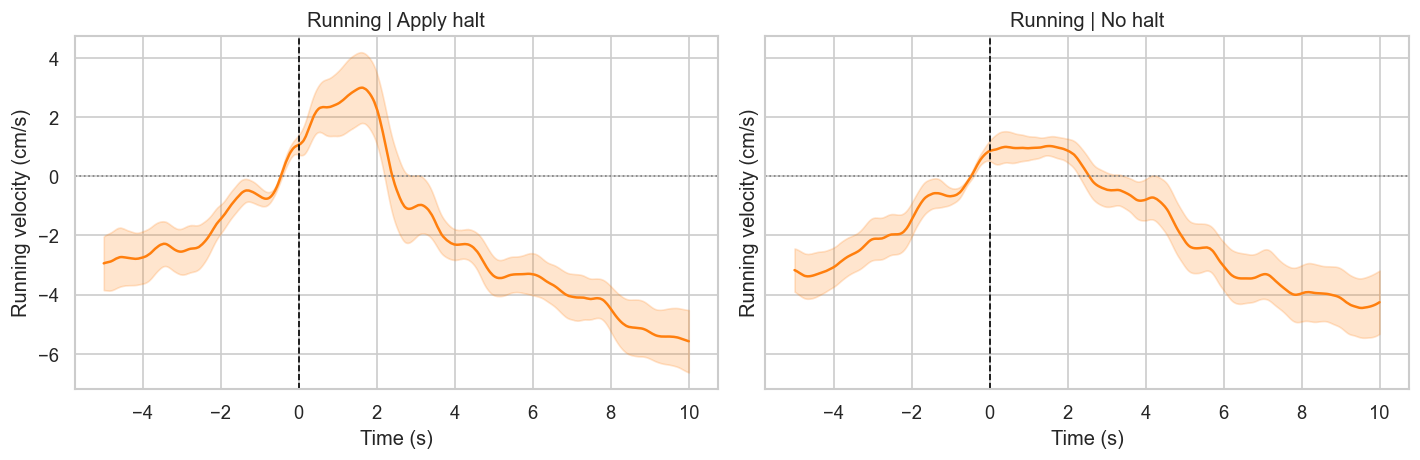

In [65]:
if running_avg_traces.empty:
    print("⚠️ Skipping running trace plots because no averaged traces are available.")
else:
    plot_groups = ["Apply halt", "No halt"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, group_name in zip(axes, plot_groups):
        subset = running_avg_traces[running_avg_traces["group"] == group_name]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#ff7f0e", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#ff7f0e", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"Running | {group_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Running velocity (cm/s)")

    plt.tight_layout()
    plt.show()

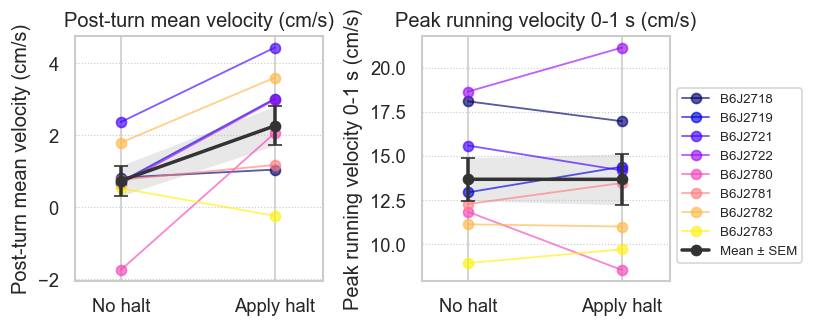

#### Running metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,1.528178,2.942889,0.021624,post_mean,Post-turn mean velocity (cm/s),No halt,Apply halt
1,8,-0.004942,-0.007455,0.994260,peak_velocity_abs_1s,Peak running velocity 0-1 s (cm/s),No halt,Apply halt


In [66]:
# Running velocity comparisons (Apply halt vs No halt)
# ----------------------------------------------------------------------

running_metric_specs = [
    ("post_mean", "Post-turn mean velocity (cm/s)"),
    ("peak_velocity_abs_1s", "Peak running velocity 0-1 s (cm/s)"),
]
running_plot_groups = ["No halt", "Apply halt"]
running_stats_df = pd.DataFrame()

if running_metrics_combined.empty:
    print("⚠️ No per-mouse running velocity metrics available for comparison")
else:
    running_mouse_colors = assign_mouse_colors_consistent(running_metrics_combined["mouse"].dropna().unique())
    available_running_specs = [
        (metric, label)
        for metric, label in running_metric_specs
        if metric in running_metrics_combined.columns
    ]

    if not available_running_specs:
        print("⚠️ Running metrics not found in aggregated data")
    else:
        subplot_width_cm = 7.5
        subplot_height_cm = 7
        fig_width = len(available_running_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(
            1,
            len(available_running_specs),
            figsize=(fig_width, fig_height),
            sharey=False,
        )
        if len(available_running_specs) == 1:
            axes = [axes]

        mean_handles = []
        running_mouse_handles: Dict[str, object] = {}
        running_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_running_specs):
            pivot = running_metrics_combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in running_plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            running_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present), dtype=float)

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                line, = ax.plot(
                    x_positions,
                    values.to_numpy(dtype=float),
                    marker="o",
                    linewidth=1.1,
                    alpha=0.65,
                    color=running_mouse_colors.get(mouse, "#1f77b4"),
                    zorder=2,
                )
                running_mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(running_mouse_handles.values())
        legend_labels = list(running_mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "running_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        plt.show()
        plt.close(fig)

        if running_stats_records:
            running_stats_df = pd.DataFrame(running_stats_records)
            display(Markdown("#### Running metrics paired t-tests"))
            display(running_stats_df)
            if OUTPUT_DIR is not None:
                running_stats_df.to_csv(OUTPUT_DIR / "running_metrics_ttests.csv", index=False)
        else:
            running_stats_df = pd.DataFrame()

### Turning velocity summary


In [67]:
# TURNING Summary statistics
# ----------------------------------------------------------------------

summary_df = summarise_results(results_df)
if summary_df.empty:
    print("⚠️ No summary statistics available")
else:
    for group_name, subdf in summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,8,8,2.293272,0.0
1,right,-1,8,8,-1.243935,0.0


### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,7,7,1.606966,0.0
1,right,-1,8,8,-0.684300,0.0


In [68]:
# Turn timing and magnitude metrics
# ----------------------------------------------------------------------

if results_df.empty:
    timing_summary_df = pd.DataFrame()
    timing_mouse_df = pd.DataFrame()
else:
    timing_columns = [
        "time_to_peak",
        "latency_to_fraction_peak",
        "peak_velocity_magnitude",
        "peak_velocity_abs_1s",
        "auc_abs",
        "decay_tau",
    ]
    timing_columns = [column for column in timing_columns if column in results_df.columns]
    if timing_columns:
        timing_summary_df = (
            results_df.groupby(["group", "direction"], dropna=False)[timing_columns]
            .agg(["mean", "sem"])
        )
        timing_summary_df.columns = [f"{metric}_{stat}" for metric, stat in timing_summary_df.columns]
        timing_summary_df = timing_summary_df.reset_index()

        timing_mouse_df = (
            results_df.groupby(["group", "mouse", "direction"], dropna=False)[timing_columns]
            .mean()
            .reset_index()
        )
    else:
        timing_summary_df = pd.DataFrame()
        timing_mouse_df = pd.DataFrame()

timing_summary_df



,group,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,Apply halt,left,0.765625,0.099679,0.162217,0.077897,15.869284,2.909617,15.869284,2.909617,5.360580,0.655812,18.060001,8.630645
1,Apply halt,right,0.586500,0.123227,0.123375,0.061521,19.299520,2.453418,19.299520,2.453418,6.243273,0.652147,34.288649,NaN
2,No halt,left,0.901714,0.053285,0.085000,0.045858,20.955384,3.183252,20.955384,3.183252,5.213417,0.352124,128.165524,118.543128
3,No halt,right,0.603000,0.137750,0.120374,0.065635,15.856811,2.245337,15.856811,2.245337,4.655894,0.668222,26.004412,NaN


In [69]:
if timing_summary_df.empty:
    print("⚠️ No timing metrics available")
else:
    for group_name, subset in timing_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### Turn timing | {title}"))
        display(subset.drop(columns=["group"], errors="ignore").reset_index(drop=True))



### Turn timing | Apply halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,0.765625,0.099679,0.162217,0.077897,15.869284,2.909617,15.869284,2.909617,5.360580,0.655812,18.060001,8.630645
1,right,0.586500,0.123227,0.123375,0.061521,19.299520,2.453418,19.299520,2.453418,6.243273,0.652147,34.288649,NaN


### Turn timing | No halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,0.901714,0.053285,0.085000,0.045858,20.955384,3.183252,20.955384,3.183252,5.213417,0.352124,128.165524,118.543128
1,right,0.603000,0.137750,0.120374,0.065635,15.856811,2.245337,15.856811,2.245337,4.655894,0.668222,26.004412,NaN


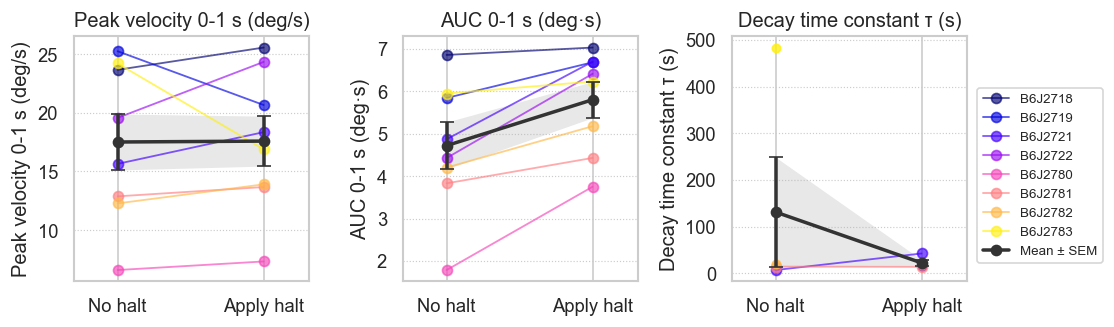

#### Turning metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,0.076513,0.054090,0.958375,peak_velocity_abs_1s,Peak velocity 0-1 s (deg/s),No halt,Apply halt
1,8,1.081570,4.089099,0.004636,auc_abs,AUC 0-1 s (deg·s),No halt,Apply halt
2,2,17.438764,0.966834,0.510734,decay_tau,Decay time constant τ (s),No halt,Apply halt


In [70]:
# Turning metric comparisons in a single figure (Apply halt vs No halt)
# ----------------------------------------------------------------------

metric_specs = [
    ("peak_velocity_abs_1s", "Peak velocity 0-1 s (deg/s)"),
    ("auc_abs", "AUC 0-1 s (deg·s)"),
    ("decay_tau", "Decay time constant τ (s)"),
]
plot_groups = ["No halt", "Apply halt"]
turning_stats_df = pd.DataFrame()

# Aggregate timing metrics directly from results_df
if results_df.empty:
    combined = pd.DataFrame()
else:
    metric_columns = [metric for metric, _ in metric_specs if metric in results_df.columns]
    if metric_columns:
        combined = (
            results_df.groupby(["mouse", "group"], dropna=False)[metric_columns]
            .mean()
            .reset_index()
        )
    else:
        combined = pd.DataFrame()

if combined.empty:
    print("⚠️ No turning metrics available for comparison")
else:
    available_specs = [(metric, label) for metric, label in metric_specs if metric in combined.columns]
    if not available_specs:
        print("⚠️ Metrics not found in aggregated data")
    else:
        subplot_width_cm = 7.5
        subplot_height_cm = 7
        fig_width = len(available_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(1, len(available_specs), figsize=(fig_width, fig_height), sharey=False)
        if len(available_specs) == 1:
            axes = [axes]

        mouse_colors = assign_mouse_colors_consistent(combined["mouse"].dropna().unique())
        mean_handles = []
        mouse_handles: Dict[str, object] = {}
        turning_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_specs):
            pivot = combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            turning_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present))

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                valid_mask = values.notna()
                if not valid_mask.any():
                    continue
                x_mouse = x_positions[valid_mask.to_numpy(dtype=bool)]
                y_mouse = values[valid_mask].to_numpy(dtype=float)
                color = mouse_colors.get(mouse, "#1f77b4")
                if x_mouse.size == 1:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linestyle="none",
                        markersize=5,
                        alpha=0.8,
                        color=color,
                        zorder=2,
                    )
                else:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linewidth=1.1,
                        alpha=0.65,
                        color=color,
                        zorder=2,
                    )
                mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(mouse_handles.values())
        legend_labels = list(mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "turning_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        plt.show()
        plt.close(fig)

        if turning_stats_records:
            turning_stats_df = pd.DataFrame(turning_stats_records)
            display(Markdown("#### Turning metrics paired t-tests"))
            display(turning_stats_df)
            if OUTPUT_DIR is not None:
                turning_stats_df.to_csv(OUTPUT_DIR / "turning_metrics_ttests.csv", index=False)



In [71]:
# Average motor velocity traces by condition and turn direction
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    per_mouse_traces = pd.DataFrame()
    avg_traces = pd.DataFrame()
else:
    per_mouse_traces = (
        trace_samples_df
        .groupby(["group", "direction", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    avg_traces = (
        per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

avg_traces

,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,left,-5.000,8.604840,1.876689,8
1,Apply halt,left,-4.999,8.602136,1.876184,8
2,Apply halt,left,-4.998,8.599452,1.875665,8
3,Apply halt,left,-4.997,8.596762,1.875152,8
4,Apply halt,left,-4.996,8.594075,1.874634,8
...,...,...,...,...,...,...
59999,No halt,right,9.996,-8.663810,1.216951,8
60000,No halt,right,9.997,-8.662637,1.217056,8
60001,No halt,right,9.998,-8.661467,1.217167,8
60002,No halt,right,9.999,-8.660293,1.217275,8


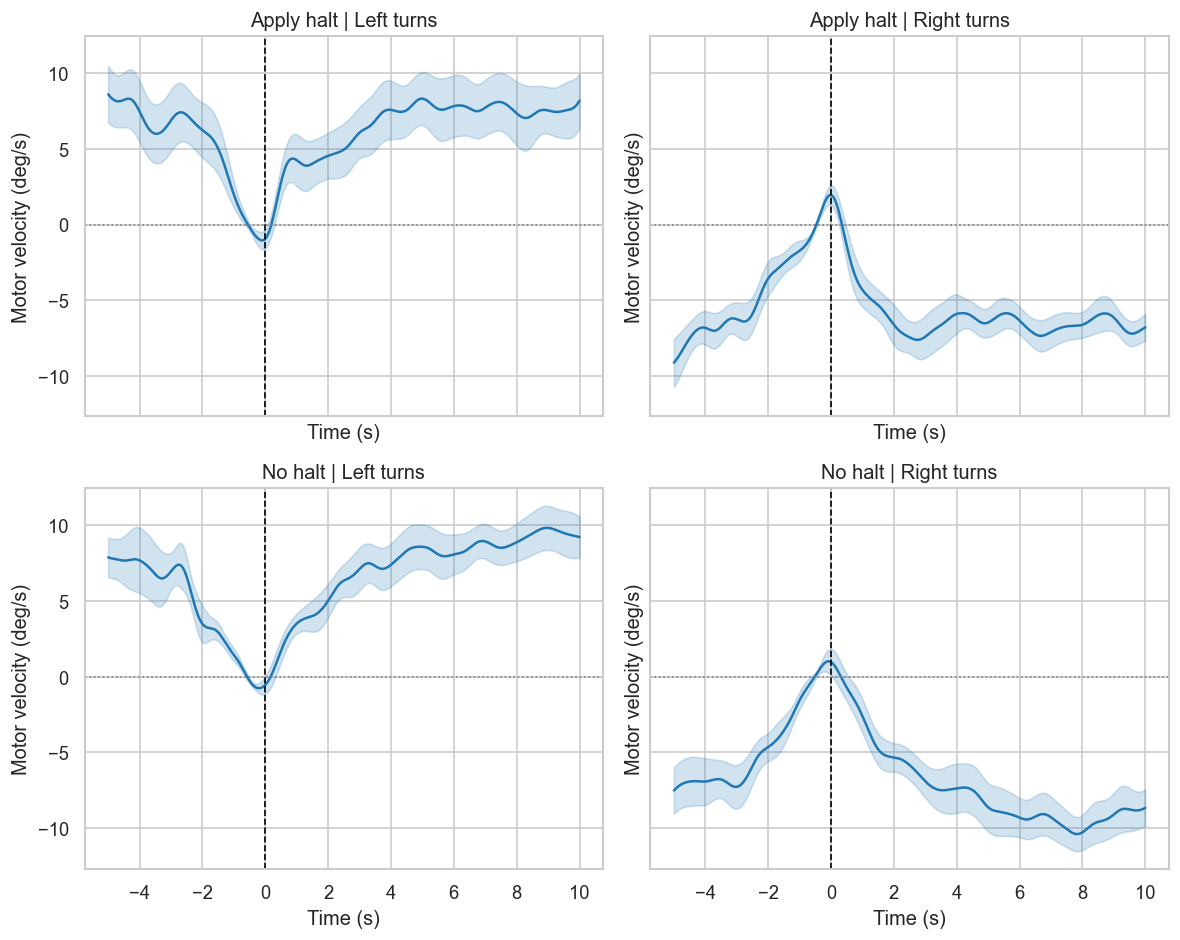

In [72]:
# 2x2 average motor velocity figure (Apply halt / No halt x Left / Right)
# ----------------------------------------------------------------------

if avg_traces.empty:
    print("⚠️ No averaged traces available for plotting")
else:
    plot_order = [
        ("Apply halt", "left"),
        ("Apply halt", "right"),
        ("No halt", "left"),
        ("No halt", "right"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (group_name, direction) in zip(axes, plot_order):
        subset = avg_traces[
            (avg_traces["group"] == group_name)
            & (avg_traces["direction"] == direction)
        ]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#1f77b4", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#1f77b4", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"{group_name} | {direction.capitalize()} turns")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Motor velocity (deg/s)")

    plt.tight_layout()
    plt.show()